# Distributed optimization algorithms
The goal of this notebook is to work on distributed optimization algorithms, which are the foundation for large scale analytics and machine learning. Specifically, we will focus on the details of stochastic gradient descent (SGD). To do so, we will work on a simple regression problem, where we will apply SGD to minimize a loss function, as defined for the problem at hand. The emphasis of this laboratory is **not** on the machine learning part: even if you've never worked on regression problems, this shouldn't prevent you from being successful in developing the Notebook.

Next, an outline of the steps we will follow in this Notebook:

* Breif introduction to linear regression
* Implementation of serial algorithms: from Gradient Descent, to Stochastic Gradient Descent
* Implementation of distributed algorithms with Apache Spark


### Initialization code

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats 
from mpl_toolkits.mplot3d import axes3d

from sklearn.datasets.samples_generator import make_regression

## A simple example: linear regression
Let’s see briefly how to use gradient descent in a simple least squares regression setting. Asssume we have an output variable $y$ which we think depends linearly on the input vector $x$. That is, we have:

$$x = \begin{bmatrix}x_1 \\ x_2 \\ \cdots \\ x_m\end{bmatrix}, y = \begin{bmatrix}y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix}$$

We approximate $y_i$ by:

$$ f_{\theta}(x_i) = \theta_1 + \theta_2 x_i$$

Define the loss function for the simple linear least squares regression as follows:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

Now, let's use scikit learn to create a regression problem. A few notes are in order:

* The call to ```make_regression``` essentially generates samples for a regression problem
* The call to ```stats.linegress``` calculates a linear least-squares regression for two sets of measurements

This means we have a sort of "basline" to experiment with our SGD implementation.

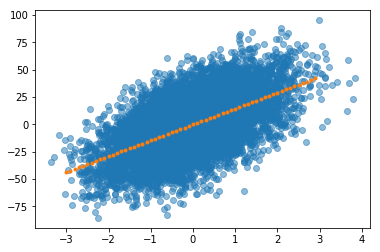

In [2]:
x, y = make_regression(n_samples = 10000, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
x = x.flatten()
slope, intercept,_,_,_ = stats.linregress(x,y)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')


## Batch gradient descent
Before delving into SGD, let's take a simpler approach. Assume that we have a vector of paramters $\theta$ and a loss function $J(\theta)$, which we want to minimize. The loss function we defined above has the form:

$$ J(\theta) = \sum_{i=1}^{m} J_i(\theta)$$

where $J_i$ is associated with the i-th observation in our data set, such as the one we generated above. The batch gradient descent algorithm, starts with some initial feasible parameter $\theta$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J(\theta^{(t)}) = \theta^{(t)} - \eta \sum_{i=1}^{m} \nabla_{\theta} J_i(\theta^{(t)}) $$

where $t$ is an iteration index, and $\eta$ is a constant controlling step-size and is called the learning rate. Note that in order to make a **single update**, we need to calculate the gradient **using the entire dataset**. This can be very inefficient for large datasets, and it is the goal of this Notebook to insist on this aspect.

In code, the main loop for batch gradient descent looks like this:

```python
for i in range(n_epochs):
  params_grad = evaluate_gradient(loss_function, data, params)
  params = params - learning_rate * params_grad
```

For a given number of iterations (also called epochs) $n_{e}$ , we first evaluate the gradient vector of the loss function using **ALL** examples in the data set, and then we update the parameters with a given learning rate. Batch gradient descent is guaranteed to converge to the global minimum for convex loss surfaces and to a local minimum for non-convex surfaces.

<div class="alert alert-warning">
<b>NOTE:</b> Who computes the gradient?
<br>
<br>
Given a loss function $J(\theta)$, the gradient with respect to paramters $\theta$ must be derived manually. In other words, given the expression of $J(\theta)$, pencil and paper are required to derive the analytical form of its gradient. Then this expression can be plugged into our code.

Recently, machine learning libraries have adopted the techniques of **automatic differentiation**, which eliminate this tedious and error prone step. Given a loss function $J(\theta)$, such libraries automatically compute the gradient.
</div>


For the linear regression case, let's derive the update step for gradient descent. Recall that we have defined:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

$$f_\theta(x_i) = \theta_1 + \theta_2 x_i$$

So we have that:

$$ \nabla_\theta J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (\theta_1 + \theta_2 x_i - y_i)^2 $$

If we explicit the partial derivatives of the gradient, we have:

$$\frac{\partial J(\theta)}{\partial \theta_1} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i)$$
$$\frac{\partial J(\theta)}{\partial \theta_2} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i) x_i$$

So now we can explicit the update rules for the two model parameters:

$$ \theta_1^{(t+1)} = \theta_1^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i)$$

$$ \theta_2^{(t+1)} = \theta_2^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i) x_i$$


### Using matrix notation
Now, before writing some code, let's see how can we simplify the above expressions using matrices. Note that this is not only useful for working on a more compact notation, but it helps reason about efficient computations using libraries such as numpy, which we will use extensively.

We firstly expressed our prediction as: $f_\theta (x_i) = \theta_1 + \theta_2 x_i$. Let's introduce a surrogate dimension for our input set $x$, such that:

$$x = 
\begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix}
$$

where we define, with a small abuse of notation, $x_i = \begin{bmatrix} 1 & x_{i}\end{bmatrix}$. Also, let's define vector $\theta = \begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix}$. 

Then, we can rewrite $f_\theta(x_i) = x_i \theta = \begin{bmatrix} 1 & x_{i}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} = \theta_1 + \theta_2 x_i$.

Let's use this notation to rewrite our gradients in matrix form.


$\nabla_\theta J(\theta) =  \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{m} (x_i \theta - y_i) x_i^T =$


$= x^T (x \theta - y) =$


$= \begin{bmatrix} 1 & 1 & \cdots & 1 \\ x_1 & x_2 & \cdots & x_m \end{bmatrix} 
\Bigg( \begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} - 
\begin{bmatrix} y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix} \Bigg)$

### Numpy arrays
With the work we did above, we can now cast everything into numpy arrays, which are efficient, and for which an efficient implementation of vector and matrix operations exists. Specifically, above we used the traditional matrix notation, where we manipulate column vectors. Hence, we express matrix operations (namely matrix products) using the traditional "row-by-column" approach.

In numpy, we avoid this formalism by using dot product operations. So, given two column vectors:
$$a= \begin{bmatrix} a_1 \\ a_2 \\ \cdots \\ a_{m}\end{bmatrix} b= \begin{bmatrix} b_1 \\ b_2 \\ \cdots \\ b_{m}\end{bmatrix}$$
we have that $a b^T = a \cdot b = a_1 b_1 + a_2 b_2 + \cdots + a_m b_m$, where $\cdot$ is the symbol we use for dot product.

<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>


</div>

In [3]:
def computeGradient(X, y, theta):
    # Compute the gradient values based on fomula Grad = X*(X.T*theta - y)   
    Grad = X.dot(X.T.dot(theta)-y)/y.size
    
    return Grad

def updateWeights(w, Grad, learningRate): 
    # Update weights based on fomula w = w - eta*Grad      
    w = w - learningRate*Grad
    
    return w

def computeLoss(X, y, theta):   
    # Compute the value of loss function given updated weight via loss = (X.T*theta - y)^2    
    temp = np.dot(X.T, theta) - y
    loss = 0.5*np.dot(temp, temp.T)/y.size
    
    return loss

def isConverged(w1, w2, eps):   
    # Checking convergence: checking the relative difference between 
    # the current weight and the previous weight is less than convergence tolerance value.  
    relDiff = np.linalg.norm(w1 - w2)/len(w1)
    
    return (relDiff < eps)

In [4]:
def BGD(xy, thetaInit, learningRate, eps, maxIter):   
    '''
    Batch Gradient Descent algorithm: computes gradient values using all training data, 
    update weight values in the opposite direction of the gradient of the objective function and 
    compute the value of loss function respect to updated weights. 
    Batch Gradient Descent algorithm will end before maxIter if the relative difference between 
    the current weight and the previous weight is less than covergence tolerance (eps).
    '''
    
    # the training data x and output y
    x, y = xy
    
    # Initial X
    X = np.vstack((np.ones(len(x)),x.T))
    
    # track of theta and loss
    thetas = [thetaInit]
    gradientValues = []
    losses = [computeLoss(X, y, thetaInit)]
    
    for i in range(maxIter):     
        # current gradient values for each iteration
        newGrad = computeGradient(X, y, thetas[-1])
        gradientValues.append(newGrad)
        
        # updated weights
        newTheta = updateWeights(thetas[-1], gradientValues[-1], learningRate)
        thetas.append(newTheta)
        
        # current value of loss function (newLoss) respect to updated weights
        newLoss = computeLoss(X, y, thetas[-1])
        losses.append(newLoss)

        # Checking convergence with current weight and previous weight
        if isConverged(thetas[-1], thetas[-2], eps):
            break
        
    return np.array(thetas), np.array(gradientValues), np.array(losses)

<div class="alert alert-block alert-info">
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>

The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

Values of the paramters using batch gradient descent:
Slope:  14.5285437282
Intercept:  -0.11672983262
Values of the paramters using scikitlearn:
Slope:  14.5151694796
Intercept:  -0.106823564161


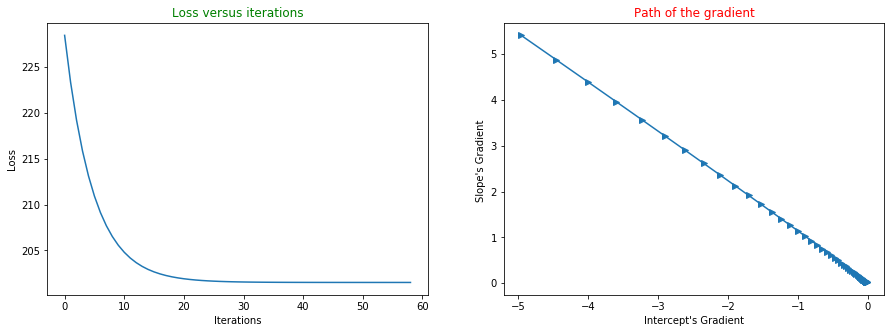

In [5]:
# Initial Parameters for Batch gradient descent function
thetaInit = np.array([-5, 20], dtype=float)
learningRate = 1e-1
eps = 1e-3
maxIter = 100
data = [x, y]

# implement Batch gradient descent with Initial Parameters
BGDWeights, BGDs, BGDlosses = BGD(data, thetaInit, learningRate, eps, maxIter)
[interceptBGD, slopeBGD] = BGDWeights[-1]

# The values of the paramters obtained through Batch Gradient Descent optimizationand scikitlearn
print("Values of the paramters using batch gradient descent:")
print("Slope: ", slopeBGD)
print("Intercept: ", interceptBGD)
print("Values of the paramters using scikitlearn:")
print("Slope: ", slope)
print("Intercept: ", intercept)

# Plot the loss function respect to iterations
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(BGDlosses)), BGDlosses)
plt.title('Loss versus iterations',color='g',fontsize=12)
plt.xlabel("Iterations")
plt.ylabel("Loss")

# Plot the path the gradient takes from its initial to its final position
plt.subplot(1,2,2)
plt.plot(BGDs[:,0],BGDs[:,1],'->')
plt.title('Path of the gradient',color='r',fontsize=12)
plt.xlabel("Intercept's Gradient")
plt.ylabel("Slope's Gradient ")
plt.show()

<div class="alert alert-warning">
<strong>Comment: </strong> Batch gradient descent smoothly converge to optimum. However, after about 25 iterations, the convergence rate is quite slow. The estimated parameters is nearly the same with one using Scikitlearn.
</div>

<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Plot the regression line, along with the training data, given the coefficients $\theta$ that you have obtained with Gradient Descent.
</div>

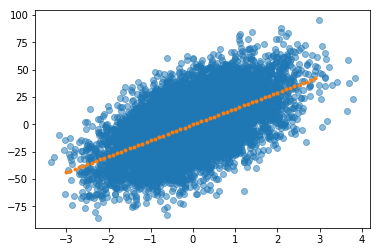

In [6]:
best_fit = np.vectorize(lambda x: x * slopeBGD + interceptBGD)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Plot a 3D surface representing: on the x,y axes the parameter values, on the z axis the loss value. Additionally, plot the trajectory of the loss function on the 3D surface, using the history you collected in the gradient_descent function you designed.

Finally, plot a contour projection of the 3D surface, along with the corresponding projection of the trajectory followed by your Gradient Descent algorithm.
</div>

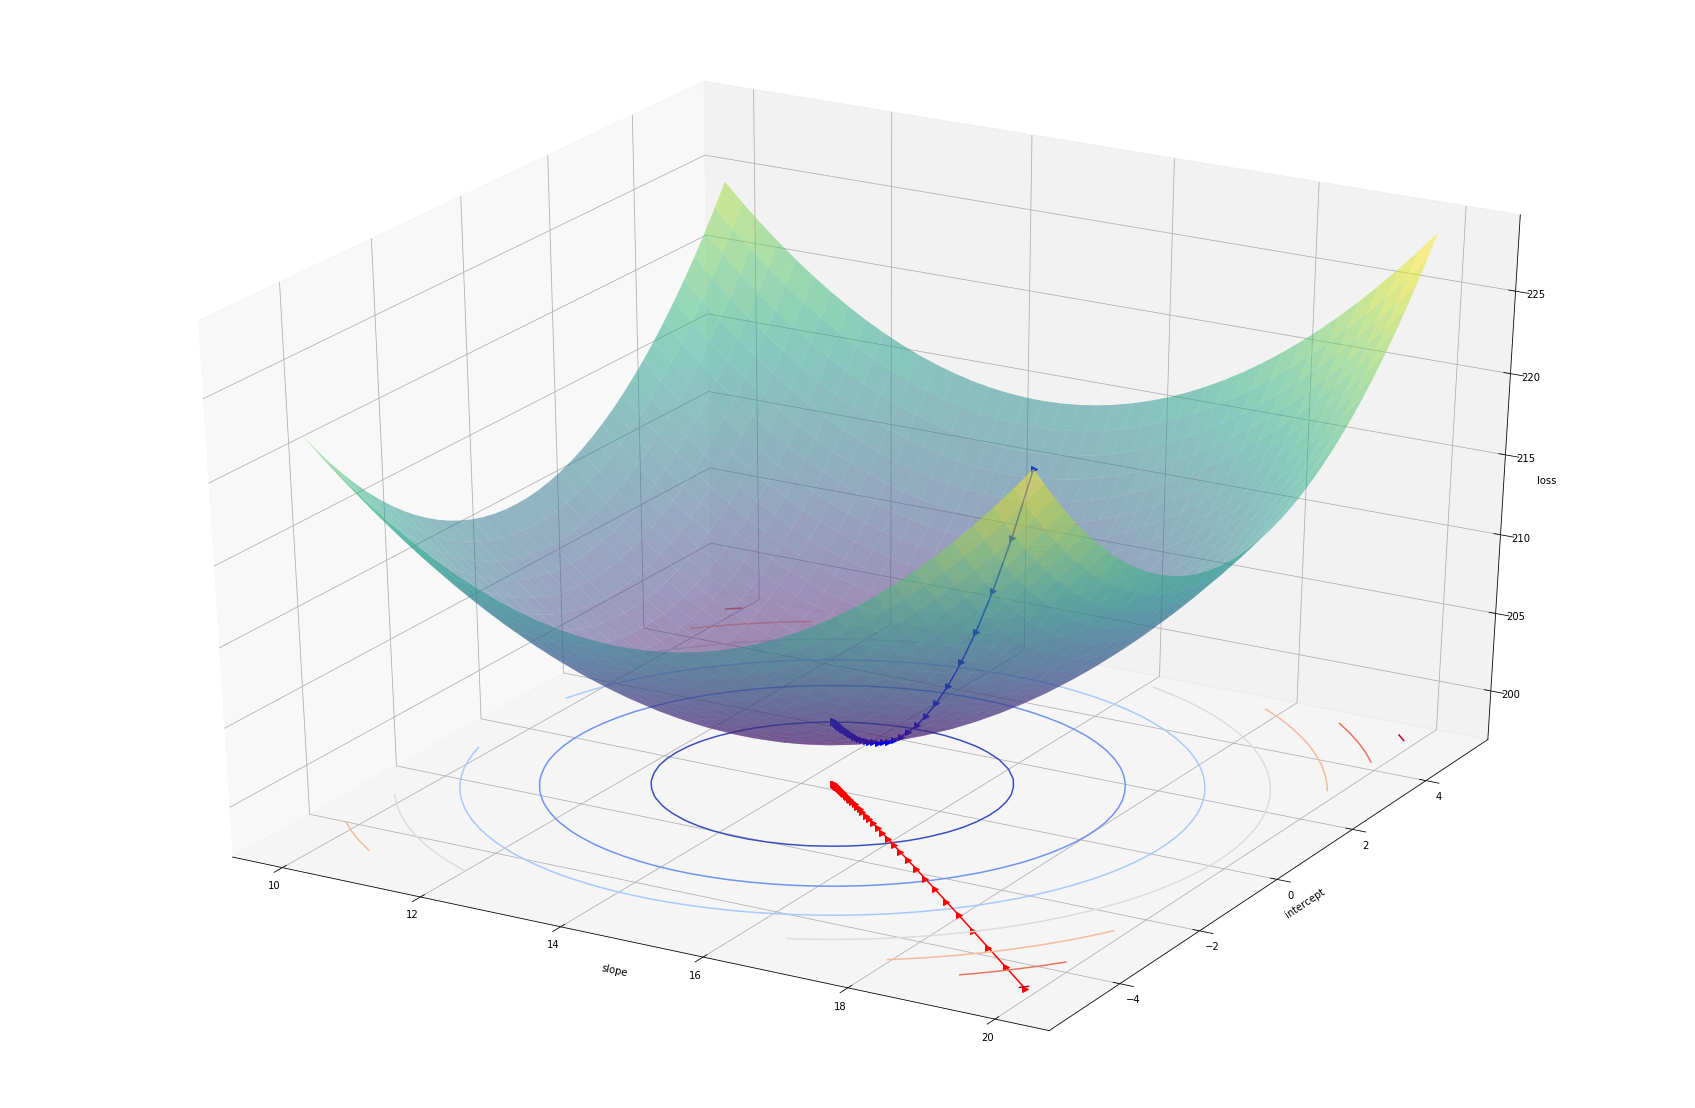

In [8]:
fig = plt.figure(figsize=(30,20))
ax = plt.axes(projection='3d')

s = np.linspace(10, 20, 40)
i = np.linspace(-5, 5, 40)

S, I = np.meshgrid(s, i)

X = np.vstack((np.ones(len(x)),x.T))
l = np.array([computeLoss(X,y,[i, s]) 
               for i, s in zip(np.ravel(I), np.ravel(S))])
L = l.reshape(S.shape)

ax.plot_surface(S, I, L, rstride=1, cstride=1, alpha=0.5, cmap='viridis', edgecolor='none')
cset = ax.contour(S, I, L, zdir='z', offset=0.98*min(BGDlosses) , cmap='coolwarm')
plt.plot(BGDWeights[:,1],BGDWeights[:,0], BGDlosses, "b->")
plt.plot(BGDWeights[:,1],BGDWeights[:,0], 0.98*min(BGDlosses), "r->")

ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.set_zlabel('loss')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Plot the path the gradient takes from its initial to its final position.

This is a two dimensional plot (because our parameter vector has size 2), with a point for each gradient value, and a line connecting the points.
</div>

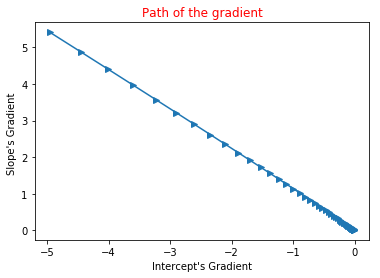

In [9]:
# Plot the path the gradient takes from its initial to its final position
plt.plot(BGDs[:,0],BGDs[:,1],'->')
plt.title('Path of the gradient',color='r',fontsize=12)
plt.xlabel("Intercept's Gradient")
plt.ylabel("Slope's Gradient ")
plt.show()

## Stochastic Gradient Descent

The gradient descent algorithm makes intuitive sense as it always proceeds in the direction of steepest descent (the gradient of $J$) and guarantees that we find a local minimum (global under certain assumptions on $J$). When we have very large data sets, however, computing $\nabla_\theta J(\theta)$ can be computationally challenging: as noted above, we must process every data point before making a single step (hence the name "batch"). 

An alternative approach to alleviate such computational costs is the Stochastic Gradient Descent method: essentially, the idea is to update the parameters $\theta$ sequentially (one data point at the time), with every observation $x_i, y_i$. Following the same notation we used for Gradient Descent, the following expression defines how to update parameters, while processing one data point at the time:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J_i(\theta^{(t)}) $$


The stochastic gradient approach allows us to start making progress on the minimization problem one step at the time. It is computationally cheaper, but it results in a larger variance of the loss function in comparison with batch gradient descent.

Generally, the stochastic gradient descent method will get close to the optimal $\theta$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we are satisfied with an **approximation** for the solution to our optimization problem. 

A full recipe for stochastic gradient descent follows:

```python 
for i in range(n_epochs):
  np.random.shuffle(data)
  for example in data:
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
```

The reshuffling of the data is done to avoid a bias in the optimization algorithm by providing the data examples in a particular order.

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Implement your own version of Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>
</div>

In [10]:
def SGD(xy, thetaInit, learningRate, eps, maxIter):
    '''
    Stochastic Gradient Descent (SGD) algorithm: computes gradient values using each point of 
    training data, update weight values in the opposite direction of the gradient of 
    the objective function and compute the value of loss function respect to updated weights. 
    SGD algorithm will end before maxIter if the relative difference between
    the current weight and the previous weight is less than covergence tolerance (eps).
    '''
    # the training data x and output y
    x, y = xy
    # Initial X
    X = np.vstack((np.ones(len(x)),x.T))
    # xy is training data matrix (combine x and y)
    xy = np.vstack((x,y)).T
    
    # track of theta and loss
    thetas = [thetaInit]
    oldTheta = thetaInit
    GDs = []
    losses = [computeLoss(X, y, thetaInit)]
    
    for i in range(maxIter):

        # shuffe training data after each epoch
        np.random.shuffle(xy)
        # accumulate gradient values
        accGrad = 0
        
        # xs, ys are input and output data sample (data point) in training data
        for xs, ys in xy:
            Xs= np.array([1, xs])
            # current 'updated' gradient values (newGrad)
            newGrad = computeGradient(Xs,ys, oldTheta)
            # updated weights (newtheta)
            newTheta = updateWeights(oldTheta, newGrad, learningRate)
            # current value of loss function (newloss) respect to updated weights
            newLoss = computeLoss(Xs, ys, newTheta)
            accGrad += newGrad
            oldTheta = newTheta

        thetas.append(newTheta)
        # gradient value after each epoch is the mean of gradient value at each data point
        GDs.append(accGrad/len(x))
        losses.append(computeLoss(X, y, thetas[-1]))

        # thetas[-1]: current weight, thetas[-2]: previous weight
        if isConverged(thetas[-1], thetas[-2], eps):
            break
    return np.array(thetas), np.array(GDs), np.array(losses)

<div class="alert alert-block alert-info">
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>

    
The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

Values of the paramters using Stochastic gradient descent:
Slope:  14.8609338286
Intercept:  -0.495038497896
Values of the paramters using scikitlearn:
Slope:  14.5151694796
Intercept:  -0.106823564161


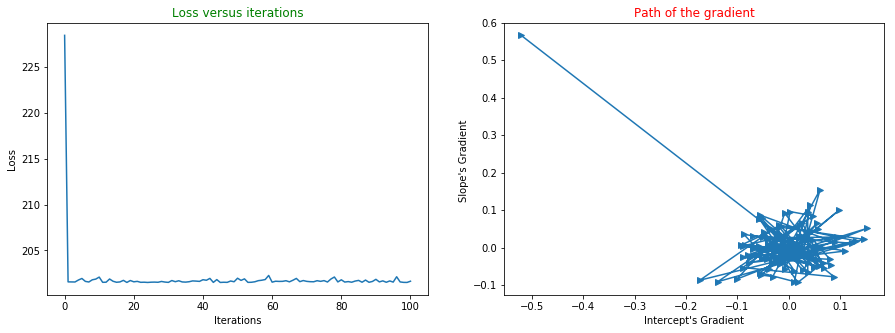

In [11]:
# Parameter configuration
thetaInit = np.array([-5, 20], dtype=float)
learningRate = 1e-3
eps = 1e-3
maxIter = 100
data = [x, y]

# implement Stochastic gradient descent with configed parameters
SGDWeights, SGDs, SGDlosses = SGD(data, thetaInit, learningRate, eps, maxIter)
[interceptSGD, slopeSGD] = SGDWeights[-1]

# The values of the paramters obtained through Gradient Descent optimizationand scikitlearn
print("Values of the paramters using Stochastic gradient descent:")
print("Slope: ", slopeSGD)
print("Intercept: ", interceptSGD)
print("Values of the paramters using scikitlearn:")
print("Slope: ", slope)
print("Intercept: ", intercept)

# Plot the loss function respect to iterations
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(SGDlosses)), SGDlosses)
plt.title('Loss versus iterations',color='g',fontsize=12)
plt.xlabel("Iterations")
plt.ylabel("Loss")

# Plot the path the gradient takes from its initial to its final position
plt.subplot(1,2,2)
plt.plot(SGDs[:,0],SGDs[:,1],'->')
plt.title('Path of the gradient',color='r',fontsize=12)
plt.xlabel("Intercept's Gradient")
plt.ylabel("Slope's Gradient ")
plt.show()

<div class="alert alert-warning">
<strong>Comment: </strong> The convergence rate of stochastic gradient descent is fast. After 2 iterations, the algorithm converge to optimal region. However, the loss funtion and the gradient path fluctuate. The estimated parameters is quite same with one using Scikitlearn.
</div>

## Mini-batch Stochastic Gradient Descent

Mini-batch gradient descent is a trade-off between stochastic gradient descent and batch gradient descent.  In mini-batch gradient descent, the cost function (and therefore gradient) is averaged over a small number of samples, which is what we call the mini-batch, and that we denote by $mb$.  This is opposed to the SGD batch size of 1 sample, and the BGD size of all the training samples. 

Let's use the notation we introduced above to rewrite the gradients in matrix form for the mini-batch variant:

$\nabla_\theta J(\theta) =  \frac{1}{2 mb} \sum_{i=1}^{mb} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{mb} (x_i \theta - y_i) x_i^T =$


$= x_{mb}^T (x_{mb} \theta - y_{mb})$


What’s the benefit of doing it this way?  First, it smooths out some of the noise in SGD, but not all of it, thereby still allowing the “kick” out of local minimums of the cost function.  Second, the mini-batch size is still small, thereby keeping the performance benefits of SGD.





<div class="alert alert-block alert-info"> 
<strong>Question 6.</strong> Implement your own version of Mini-batch Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to extract mini-batches from the training data.
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>
</div>

In [12]:
def MBSGD(xy, thetaInit, batchSize, learningRate, eps, maxIter):
    '''
    An implementation of Stochastic Gradient Descent (SGD) algorithm that computes gradient
    values using groups of data point in training data, update weight values in the opposite 
    direction of the gradient of the objective function and compute the value of loss function
    respect to updated weights. MBSGD algorithm will end before maxIter if the relative difference
    between the current weight and the previous weight is less than covergence tolerance (eps).
    '''
    # the training data x and output y
    x, y = xy
    # Initial X
    X = np.vstack((np.ones(len(x)),x.T))
    # xy is training data matrix (combine x and y)
    xy = np.vstack((x,y)).T
    
    # track of theta and loss
    thetas = [thetaInit]
    oldTheta = thetaInit
    GDs = []
    losses = [computeLoss(X, y, thetaInit)]
    
    for i in range(maxIter):      
        # shuffe training data after each epoch
        np.random.shuffle(xy)
        # accumulate gradient values
        accGrad = 0
        # number of batch in training data given batch size
        Nb_batches = int(len(xy)/batchSize)
        
        for bid in range(Nb_batches):
            batch = xy[bid*batchSize:(bid+1)*batchSize]
            xb = batch[:,0]
            yb = batch[:,1]
            Xb= np.vstack((np.ones(len(xb)),xb.T))
            
            # current 'updated' gradient values (newGrad)
            newGrad = computeGradient(Xb, yb, oldTheta)
            # updated weights (newtheta)
            newTheta = updateWeights(oldTheta, newGrad, learningRate)
            accGrad += newGrad
            oldTheta = newTheta
        
        thetas.append(newTheta)
        # gradient value after each epoch is the mean of gradient value at each minibatch of data points
        GDs.append(accGrad/Nb_batches)
        losses.append(computeLoss(X, y, thetas[-1]))
        
        # thetas[-1]: current weight, thetas[-2]: previous weight
        if isConverged(thetas[-1], thetas[-2], eps):
            break
    return np.array(thetas), np.array(GDs), np.array(losses)

<div class="alert alert-block alert-info"> 
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>


The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

Values of the paramters using mini-batch stochastic gradient descent:
Slope:  14.4816090731
Intercept:  -0.18567973605
Values of the paramters using scikitlearn:
Slope:  14.5151694796
Intercept:  -0.106823564161


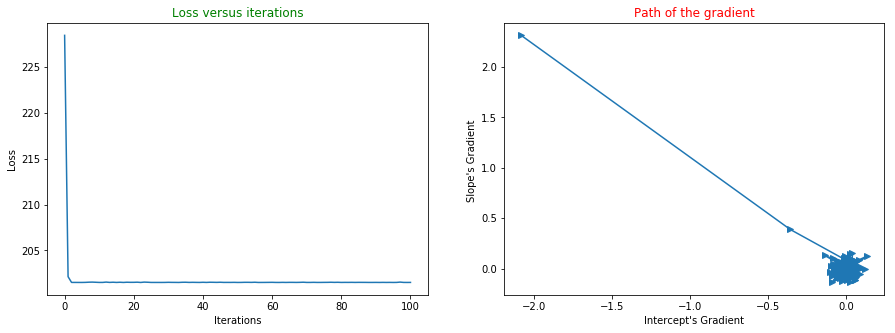

In [13]:
# Parameter configuration
thetaInit = np.array([-5, 20], dtype=float)
learningRate = 1e-2
batchSize = 50
eps = 1e-3
maxIter = 100
data = [x, y]

# implement Stochastic gradient descent with configed parameters
MBSGDWeights, MBSGDs, MBSGDlosses = MBSGD(data, thetaInit, batchSize, learningRate, eps, maxIter)
[interceptMBSGD, slopeMBSGD] = MBSGDWeights[-1]

# The values of the paramters obtained through Mini-batch Stochastic Gradient Descent optimizationand scikitlearn
print("Values of the paramters using mini-batch stochastic gradient descent:")
print("Slope: ", slopeMBSGD)
print("Intercept: ", interceptMBSGD)
print("Values of the paramters using scikitlearn:")
print("Slope: ", slope)
print("Intercept: ", intercept)

# Plot the loss function respect to iterations
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(MBSGDlosses)), MBSGDlosses)
plt.title('Loss versus iterations',color='g',fontsize=12)
plt.xlabel("Iterations")
plt.ylabel("Loss")

# Plot the path the gradient takes from its initial to its final position
plt.subplot(1,2,2)
plt.plot(MBSGDs[:,0],MBSGDs[:,1],'->')
plt.title('Path of the gradient',color='r',fontsize=12)
plt.xlabel("Intercept's Gradient")
plt.ylabel("Slope's Gradient ")
plt.show()

<div class="alert alert-warning">
<strong>Comment: </strong> The convergence rate of stochastic gradient descent is quite fast. After 3 iterations, the algorithm converge to optimal region. The loss function and gradient path is smoother than stochastic gradient descent. The estimated parameters is nearly the same with one using Scikitlearn.
</div>

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Compare the loss rate of the three approachs, Gradient Descent, Stochastic Gradient Descent, Mini-batch Stochastic Gradient Descent, by plotting in the same figure, the loss rate as a function of iterations. 


Comment the behavior of the three algorithms.
</div>

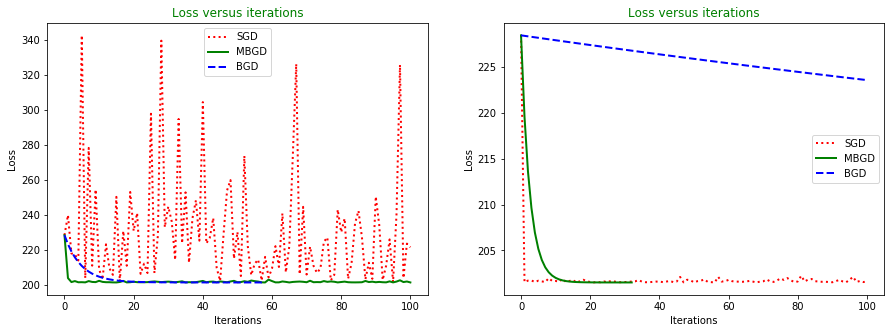

In [14]:
# Parameter configuration
initialWeights = np.array([-5, 20], dtype=float)
batchSize = 50
convergenceTol = 1e-3
numIterations = 100
data = [x, y]

stepSize = 1e-1
# implement Stochastic gradient descent with configed parameters
BGDWeights, BGDs, BGDlosses = BGD(data, initialWeights, stepSize, convergenceTol, numIterations)
[interceptBGD, slopeBGD] = BGDWeights[-1]

# implement Stochastic gradient descent with configed parameters
SGDWeights, SGDs, SGDlosses = SGD(data, initialWeights, stepSize, convergenceTol, numIterations)
[interceptSGD, slopeSGD] = SGDWeights[-1]

# implement Stochastic gradient descent with configed parameters
MBSGDWeights, MBSGDs, MBSGDlosses = MBSGD(data, initialWeights,batchSize, stepSize, convergenceTol, numIterations)
[interceptMBSGD, slopeMBSGD] = MBSGDWeights[-1]

# Plot loss rate versus iteration of the three approachs: Gradient Descent, Stochastic Gradient Descent, Mini-batch Stochastic Gradient Descent
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(SGDlosses)), SGDlosses, color='r', linewidth=2, linestyle='dotted', label="SGD")
plt.plot(np.arange(len(MBSGDlosses)), MBSGDlosses , color='g', linewidth=2, linestyle='solid', label="MBGD")
plt.plot(np.arange(len(BGDlosses)), BGDlosses, color='b', linewidth=2, linestyle='dashed', label="BGD")
plt.legend()
plt.title('Loss versus iterations',color='g',fontsize=12)
plt.xlabel("Iterations")
plt.ylabel("Loss")

stepSize = 1e-3
# implement Stochastic gradient descent with configed parameters
BGDWeights, BGDs, BGDlosses = BGD(data, initialWeights, stepSize, convergenceTol, numIterations)
[interceptBGD, slopeBGD] = BGDWeights[-1]

# implement Stochastic gradient descent with configed parameters
SGDWeights, SGDs, SGDlosses = SGD(data, initialWeights, stepSize, convergenceTol, numIterations)
[interceptSGD, slopeSGD] = SGDWeights[-1]

# implement Stochastic gradient descent with configed parameters
MBSGDWeights, MBSGDs, MBSGDlosses = MBSGD(data, initialWeights,batchSize, stepSize, convergenceTol, numIterations)
[interceptMBSGD, slopeMBSGD] = MBSGDWeights[-1]

# Plot loss rate versus iteration of the three approachs: Gradient Descent, Stochastic Gradient Descent, Mini-batch Stochastic Gradient Descent
plt.subplot(1,2,2)
plt.plot(np.arange(len(SGDlosses)), SGDlosses, color='r', linewidth=2, linestyle='dotted', label="SGD")
plt.plot(np.arange(len(MBSGDlosses)), MBSGDlosses , color='g', linewidth=2, linestyle='solid', label="MBGD")
plt.plot(np.arange(len(BGDlosses)), BGDlosses, color='b', linewidth=2, linestyle='dashed', label="BGD")
plt.legend()
plt.title('Loss versus iterations',color='g',fontsize=12)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

<div class="alert alert-warning">
<strong>Comment: </strong> The above two diagrams are respective to the learning rate at 0.1 and 0.001. The plot illustrate the performance outcomes of Batch Gradient Descent (BGD), Stochastic Gradient Descent (SGD), and Mini-Batch Stochastic Gradient Descent (MBSGD).

<li>BGD performs redundant computations, re-computes gradients for similar examples on the whole dataset before each parameter update, it can be very slow and is intractable for datasets that don't fit in memory. BGD also doesn't allow us to update our model online. Furthermore, the training time of BDG also depends on the learning rate as small learning rate would lead to slow convergence as figure 2. However, batch gradient descent is guaranteed to converge to the optimum.</li>

<li>SGD works better with gradient update redundancy of BGD by performing one update at a time. Therefore, It is usually much faster and can also be used to learn online. However, SGD performs frequent updates with a high variance then the objective function to fluctuate heavily (in Figure 1). Figure 2 shows that when we slowly decrease the learning rate, SGD shows the same convergence behavior as batch gradient descent as almost certainly converging to optimum. Another important point is we want to avoid providing the training examples in a meaningful order to our model as this may bias the optimization algorithm. Consequently, it is often a good idea to shuffle the training data after every epoch.</li>

<li>MBSGD is the trade-off between the accuracy of the parameter update and the time it takes to perform an update. It can be consider as the balance solution between BGD and SGD since it reduces the variance of the parameter updates, which not only lead to more stable convergence (compared to stochastic gradient descent) and but also converges faster (compared to batch gradient descent).</li>

<li>Choosing appropriate learning rate is essential. If the learning rate is too small, it cost more time to move to the convergence. An excessively high learning rate can hinder convergence and cause the loss function to fluctuate around the convergence region even to diverge. We can be adjusting the learning rate during training by using back-tracking line search.</li>

<li>Choosing appropriate convergence condition: For instance, SGD and MBSGD take a few iterations to reach the optimal region however it still oscillate around this region. If the convergence tolerance value is small in this case, it's hard for these algorithm break the loop condition anf then take a lot of redundancy iteration. And if the convergence tolerance value is big, it can make algorithm stop before reaching the optimal value.</li>
</div>

***

## Distributed Mini-Batch Stochastic Gradient Descent
We're now ready to study the problem of distributed, mini-batch stochastic gradient descent. Clearly, so far we've worked with very small datasets: as a consequence it is hard to appreciate the computational bottleneck of serial implementations. But before we delve into an experimental setting, and try to spice things up with larger datasets, let's focus on the problem per se.

The problem statement is as follows: we need to design a distributed version of the algorithm we examined above, that is the Mini-Batch Stochastic Gradient Descent. In the interest of time, and also because in this laboratory we want to work with Apache Spark, we will look at **synchronous** distributed algorithms. Don'y worry, things will be much more clear in the next section!

As a complement to this introduction, here's a list of references that are useful for this Notebook, and more generally that constitute the base for those of you interested in distributed optimization algorithms, an important element of large-scale machine learning.

The first reference is a research paper that was published in 2010, in a very important conference called NIPS. I suggest to have a look at section 1 only, unless you want to pursue a PhD, in which case I strongly suggest to contact me, I'm always looking for bright students to work with!

The following references are a collection of pointers to real code, which essentially implement the ideas presented in the research paper we mentioned. Beware, this is Scala code, whereas we use Python. Nevertheless, you'll find a lot of inspiring hints for your own code. Again, I suggest to start simple, and avoid the regularization part. On another note, it is interesting to look at code that is meant to be integrated as a contribution to a popular open source software, such as Apache Spark, and in particular MLLib. This is in stark contrast to the "coding style" we adopt in this Notebook, which is to be considered experimental, and far from being compliant with any principled approach to software engineering.


#### References
* Parallelized Stochastic Gradient Descent: http://martin.zinkevich.org/publications/nips2010.pdf
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/ParallelizedSGD.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/SGDUpdater.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/test/scala/org/apache/spark/mllib/optimization/ParallelizedSGDSuite.scala

### Some useful hints to design your distibuted algorithm

In this Notebook we will use Apache Spark, which is simply a fantastic tool! As we've learned in class (and this is actually true for Hadoop MapReduce as well as for any other distributed computing framework embracing the Bulk Synchrnous Parallel (BSP) programming model), Apache Spark features a synchronization barrier that really helps in dealing with distributed computations. To simplify the discussion (a much more profound treatment of the subject can be found in this nice book http://www.parallel-algorithms-book.com/), in Apache Spark workers operate synchronously, in that the result of their computation, when aggregated or distributed, is processed only when **all** workers are done. So on the one hand, this simplifies the programming model, while on the other hand, this might introduce "stragglers", that is slow workers that penalize the performance of your distributed algorithm.

So what are the basic steps you should follow to design and implement your distributed algorithm?

#### Algorithm pseudo-code
In what follows, we outline the algorithm pseudo-code, to help you think about your algorithm implementation.

```python
for i in range(iterations)
  
  # Randomly partition the input, giving T examples to each machine.
  mini_batches = sample(input_data)

  # Initialize random paramters
  params = initialize
  
  # This part executes in parallel, on each of the k worker machines
  # This is essentially the same code as for the serial implementation
  # Indeed, we're working on an embarassingly parallel formulation
  for data in mini_batch: 
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
    
  # Here we aggregate from all machines, and compute the update for iteration i
  # The update is simply the average of all updates coming from each of the k worker machines
  Aggregate from all computers params = average(params_k)
```

#### Input data and parameters
As for the input data, we want to use the same procedure we used from the beginning of the Notebook: we use scikit learn to generate our $x$ and $y$.
Then, you have to find ways to **partition** this data across the machines you have in your cluster. The method ```sc.parallelize``` comes handy here.

Once you have a parallel collection, that takes the form of an ```RDD```, you'll have to ```sample``` from it, to create random mini batches, each of which will be used **independently** by each worker machine to process its own data. Be careful that here we want to **keep the data partitioning** of our original data. You should be wise enough to lookup for the PySpark API to get the details of the methods we suggested here: ```sample``` and ```mapPartitions```.

Last but not least, we have to take care about the parameters! The initial parameter values, as well as any updates to them, must be shipped to all worker machines. There are various ways to do this, exploiting the great flexibility of Apache Spark. This data could be serialized and shipped along with the code each task should execute. However, a much more efficient method to do this is to exploit what we have learned in class, namely ```broadcast variables```. You might argue that for our simple Notebook, since the parameter vector is of size 2, this is not a big deal. However, for different scenarios, like big models, having an efficient primitive to ship a lot of data to workers is a big plus: remember that broadcast variables are sent to workers using a protocol very similar to BitTorrent, a famous peer-to-peer content distribution system.

#### Driver vs. workers

Now, to clarify even further what we expect from our Apache Spark program, here's some additional information about the roles of each component invovled in the execution of the pseudo-code outlined above.


Essentially, the ```driver``` machine (the one where the ```SparkContext``` is created), is the one responsible for executing the "serial" part of the algorithm: prepare and dispatch data, and wait for the contributions coming from all machines.


Instead, the ```worker``` machines receive their task to execute, proceed independently (some faster than others), and send their updates to the driver. The driver will **wait for all updates from workers** before proceeding with the final aggregation.

#### Additional hints

As you might have heard in class, Apache Spark has a lot of surprises. On of such cool methods allow you to define the way data is aggregated. Indeed, you surely realized that (in the old Hadoop MapReduce jargon) we're talking about a "map only job": workers "map" on their minibatch, computing partial gradient updates, then send everything (more or less at the same time) to the driver machine. At the scale of this Notebook, this is rather harmless. Instead, at larger scale, this could create "congestion" in the driver: a nice solution to this would be to have the possibility to aggregate data along a tree-structure, which would involve worker machines as well as the driver.


One final note. In case you wonder how to produce an ```iterable``` in python with a singleton in it, just ```return (variable, )```.

<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Implement your own version of Mini-Batch, Stochastic Gradient Descent, as a **distributed** algorithm.

    
The output of your cell should contain the following information:
<ul>
<li> The values of the paramters obtained through Gradient Descent optimization </li>
<li> The values of the paramters obtained with the above cell, using scikitlearn </li>
<li> A plot of the loss versus iterations </li>
<li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

In [17]:
def distributed_mini_batch_SGD(xy, theta, eta, eps, max_iter):     
    '''
    An implementation of distributed mini-batch Stochastic Gradient Descent (DMBSGD) algorithm 
    that computes gradient values using groups of data point in training data, update weight values in
    the opposite direction of the gradient of the objective function and compute the value of loss 
    function respect to updated weights. These operations are implemented on each partition of cluster 
    and then take average values. DMBSGD algorithm will end before max_Iter if the relative difference 
    between the current weight and the previous weight is less than covergence tolerance (eps).
    '''
    # create read-only variables (weight and learning rate) cached on each machine
    bcTheta = sc.broadcast(theta)
    bcEta = sc.broadcast(eta)
    
    def mini_batch_stochastic_gradient_descent(data):
        '''
        An implementation of mini-batch Stochastic Gradient Descent (MBSGD) algorithm that computes
        gradient values using groups of data point in traning data, update weight values in the opposite direction 
        of the gradient of the objective function and compute the value of loss function respect to updated weights. 
        '''
        xy = np.array(list(data))
        x = xy[:,0]
        y = xy[:,1]

        # x matrix with "1" column
        X = np.vstack((np.ones(len(x)),x.T))

        # previous weights
        oldtheta = bcTheta.value
        # current gradient values
        newGrad = computeGradient(X,y,oldtheta)
        # updated weights
        newtheta = updateWeights(oldtheta,newGrad,bcEta.value)
        # current values of loss function respect to updated weight
        newloss = computeLoss(X, y, newtheta)
        
        return ([newtheta, newloss, newGrad, 1], )
        
    def stochastic_gradient_descent(data):
        '''
        An implementation of Stochastic Gradient Descent (SGD) algorithm that computes gradient values
        using each data point in traning data,  update weight values in the opposite direction of the 
        gradient of the objective function and compute the value of loss function respect to updated weights. 
        '''
        
        # accumulate gradient values
        accGrad = 0
        # accumulate loss values
        accLoss = 0
        # previous weights
        oldtheta =  bcTheta.value
        for xs, ys in data:
            Xs= np.array([1, xs])
            # current gradient values
            newGrad = computeGradient(Xs,ys,oldtheta)
            # updated weights
            newtheta = updateWeights(oldtheta,newGrad,bcEta.value)
            # current value of loss function respect to updated weights
            newloss = computeloss(Xs, ys, newtheta)
            accGrad += newGrad
            accLoss += newloss
            oldtheta = newtheta

        return ([newtheta, accLoss/len(x), accGrad/len(x), 1], )
    
    # x, y are input and output data matrice respectively
    x, y = xy
    
    # X is extended input matrix by adding "1" column
    X = np.vstack((np.ones(len(x)),x.T))
    
    # data is training data matrix (combine x and y)
    data = np.vstack((x,y)).T
    
    # create parallelized collection whose form is RDD (dataRDD) based on training data (data)
    # divide the dataset into 6 partions using the number of partitions parameter
    Nb_partitions = 6
    dataRDD = sc.parallelize(data, Nb_partitions)
    
    #history vectors
    X = np.vstack((np.ones(len(x)),np.array(x).T))
    losses=[computeLoss(X, np.array(y), bcTheta.value)]
    GDs=[]
    thetas=[bcTheta.value]
    
    # fraction of the input data set that should be used for one iteration of DMBSGD
    miniBatchFraction = 0.7
    
    # Before reaching stop condition (max_iter), at each itaration, 3 below steps will be implemented:
    # 1. A mini-batch data will be selected from data in each partition via 'sample' action given 
    # miniBatchFraction parameter (the probability that a data point in partition will be selected into mini-batch).
    # 2. Using 'mapPartitions' transformation to apply minibatch stochastic gradient descent algorithm
    # to computes gradient values, loss value, weights for each partition.
    # 3. Using 'reduce' action to take average gradient values, loss value, weights from the values in each
    # partition at step 2
    for i in range(max_iter):
    
        batchRDD = dataRDD.sample(False, miniBatchFraction, 42 + i)
        GradRDD = batchRDD.mapPartitions(mini_batch_stochastic_gradient_descent)
        res = GradRDD.reduce(lambda res1, res2: [res1[0]+res2[0], res1[1]+res2[1], res1[2]+res2[2], res1[3]+res2[3]])

        thetas.append(res[0]/res[3])
        losses.append(res[1]/res[3])
        GDs.append(res[2]/res[3])
        
        # update broadcast weight for next iteration
        bcTheta = sc.broadcast(thetas[-1])
        
        # thetas[-1]: current weight, thetas[-2]: previous weight
        if isConverged(thetas[-1], thetas[-2], eps):
            break
    
    return np.array(thetas), np.array(GDs), np.array(losses)

<div class="alert alert-warning">
<strong>Comment: </strong> In this distributed version, we implement two type of gradient descent methods: stochastic gradient descent (following the paper published in NIPS conference) and mini-batch stochastic gradient descent (following the requirement). And then, we use mini-batch stochastic gradient descent for this exercise. For data in each partition that implemented by each worker, we consider about 70% of these data (miniBatchFraction = 0.7) to compute gradient value for each iteration.
</div>

Values of the paramters using distributed mini-batch stochastic gradient descent:
Slope:  14.8551165223
Intercept:  -0.575557594862
Values of the paramters using scikitlearn:
Slope:  14.5151694796
Intercept:  -0.106823564161


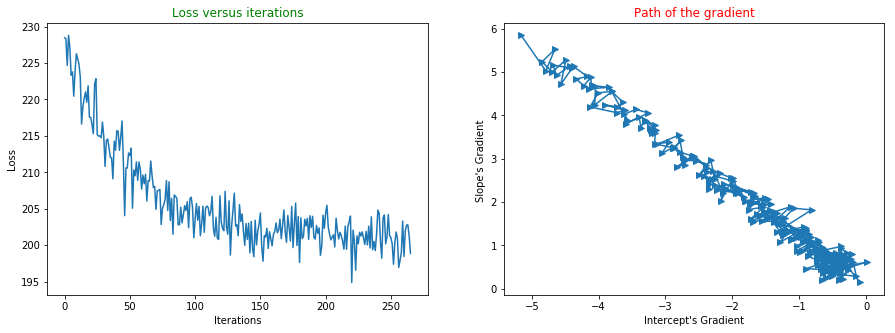

In [18]:
# Parameter configuration
initialWeights = np.array([-5, 20], dtype=float)
stepSize = 1e-2
convergenceTol = 1e-3
numIterations = 1000
data = [x, y]

# implement Distributed Mini-batch Stochastic gradient descent with configed parameters
DMBSGDWeights, DMBSGDs, DMBSGDlosses = distributed_mini_batch_SGD(data, initialWeights, stepSize, convergenceTol, numIterations)
[interceptDMBSGD, slopeDMBSGD] = DMBSGDWeights[-1]

# The values of the paramters obtained through Distributed Mini-batch Stochastic Gradient Descent optimizationand scikitlearn
print("Values of the paramters using distributed mini-batch stochastic gradient descent:")
print("Slope: ", slopeDMBSGD)
print("Intercept: ", interceptDMBSGD)
print("Values of the paramters using scikitlearn:")
print("Slope: ", slope)
print("Intercept: ", intercept)

# Plot the loss function respect to iterations
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(DMBSGDlosses)), DMBSGDlosses)
plt.title('Loss versus iterations',color='g',fontsize=12)
plt.xlabel("Iterations")
plt.ylabel("Loss")

# Plot the path the gradient takes from its initial to its final position
plt.subplot(1,2,2)
plt.plot(DMBSGDs[:,0],DMBSGDs[:,1],'->')
plt.title('Path of the gradient',color='r',fontsize=12)
plt.xlabel("Intercept's Gradient")
plt.ylabel("Slope's Gradient ")
plt.show()

<div class="alert alert-warning">
<strong>Comment: </strong> The distributed mini-batch stochastic gradient descent algorithm can converge to optimal region. However, the loss funtion as well as the gradient path fluctuate in the way it moves to the optimal region. The estimated parameters is quite good and nearly same with one using Scikitlearn.
</div>

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Inspecting your input data, and its partitioning.
<br>

Answer the following questions:
<ul>
    <li>What is the best way to partition your data, given your cluster configuration? How many partitions did you chose</li>
    <li>Given the number of partitions from the first point, how many RDD blocks is your data broken into?</li>
    <li>What would be different if you were to concieve the same algorithm digesting input data stored as a CSV file on HDFS? Argue about how to "ship" data to worker machines, partitions, blocks, etc...</li>
</ul>
</div>


**```[HINT]```** The questions above are best answered by looking at the Spark Master Web UI.

<div class="alert alert-warning">
    <strong>What is the best way to partition your data, given your cluster configuration? How many partitions did you chose</strong><br>
The optimal number of partitions we should divide dataset should be the same with the number of total cores in the cluster. Our cluster contains 2 workers (each worker has 3 cores and 10.5 GB memory). Therefore, we divide our data into 6 partitions.
<br><br>

<strong>Given the number of partitions from the first point, how many RDD blocks is your data broken into?</strong><br>
    Since we divide our dataset into 6 partitions then the number of RDD block is 6.
    <br>   <br>
<strong>What would be different if you were to concieve the same algorithm digesting input data stored as a Argue about how to "ship" data to worker machines, partitions, blocks, etc...</strong><br>
 PySpark can create distributed datasets from any storage source supported by Hadoop, including the local file system, HDFS, HBase, Amazon S3, etc. Then if the CSV file was stored in HDFS, that means it already divided into different blocks and stored on different machines. Consequently, the file is already operated in parallel and it does not need to be recalled as the "parallelize collection" process.<br>

Secondly, the SparkDriver can manage the locations of the DataNode via NameNode in HDFS, and it also prioritizes on "Locality" processing. Hence, it will focus on accomplishing the tasks which closer to the data in order to minimize the data transferring time (avoid network I/O). That means it will consider processing the data on the same machine, then on the same Rack.
</div>

<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Finding bottlenecks.

<ul>
    <li>What is the bottleneck in the current implementation of your algorithm?</li>
    <li>Can you nail down exactly which method is causing this bottleneck?</li>
    <li>Can you suggest ways to mitigate or eliminate the bottleneck?</li>
</ul>
</div>

<div class="alert alert-warning">
<strong>What is the bottleneck in the current implementation of your algorithm?</strong><br>

After each worker finished its computations which related to the gradient, loss values, etc then it will send the calculation results back to the SparkDriver. Hence, the SparkDriver will aggregate these result for the next iteration. Consequently, the SparkDriver need to wait for all of the calculations from workers. Along with it, if the higher number of workers lead to the larger workloads that SparkDriver has to compute in overall. That would lead to the bottleneck issue.<br><br>
    
<strong>Can you nail down exactly which method is causing this bottleneck?</strong><br>
    The bottleneck issue happened during the "Reduce" action since this stage collects all the calculated results from SparkWorkers and consolidate it.<br><br>
    
<strong>Can you suggest ways to mitigate or eliminate the bottleneck?</strong><br>
To mitigate the bottleneck, we can use variables type accumulator. Spark functions used variables defined in the driver program and local copied of variables will be generated. Accumulator are shared variables which help to update variables in parallel during execution and share the results from workers to the driver. That help to reduce the amount of data that workers transfer to driver.<br>
Another way can be applied on this issue is to aggregate data along a tree-structure. Its pattern is based on multi-level aggregation trees in which data are combined partially on a small set of executors before they are sent to the driver, which dramatically reduces the load the driver has to deal with. Some functions on this tructure can be treeReduce and treeAggregate.
</div>

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison of serial vs. distributed algorithms.
</div>

Given all the implementation effort you did so far, this question is about an experimental study on scalability. Given input data sizes in the range $[10^2, 10^3, 10^4, 10^5]$, collect the run-time and the loss rate at convergence for all variants of the serial algorithms and for the distributed one. Produce a plot with 2 y-axis, one for the run-time, one for the loss rate, and one x-axis with the input data size.

Discuss your results.


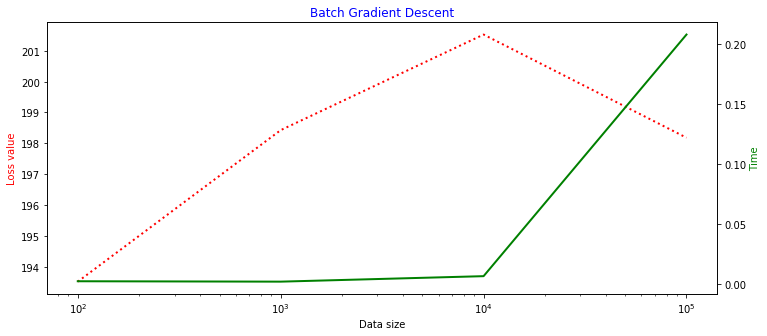

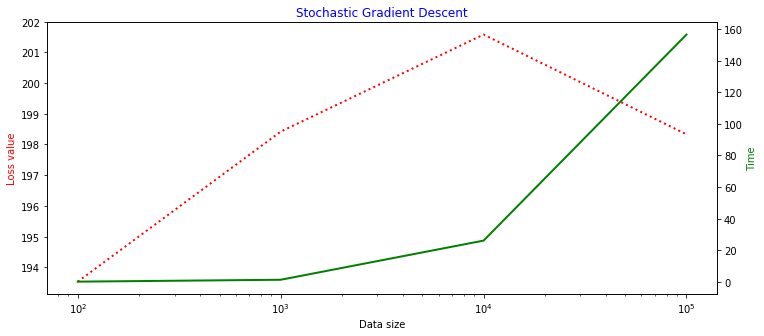

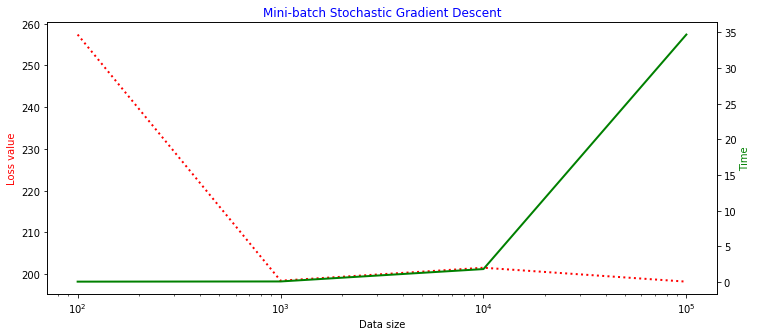

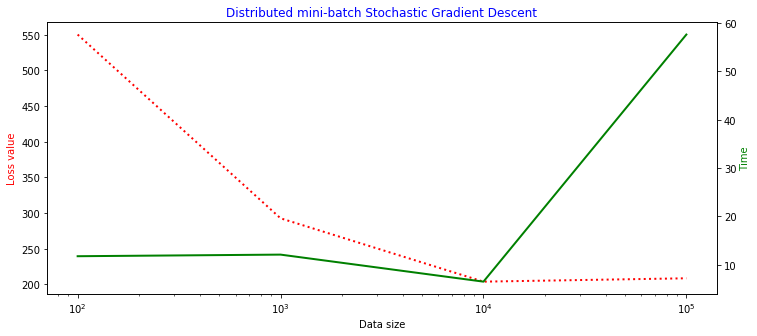

In [19]:
import time

def implement_algo(data_size, algo_name):
    '''
    An implementation of selected algorithm (algo_name)
    that computes loss function and running time given trainning data size. 
    '''   
    # create training data given data size
    x, y = make_regression(n_samples = data_size, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
    x = x.flatten()
    
    # parameter configuration
    initialWeights = np.array([-5, 20], dtype=float)
    batchSize = 50
    convergenceTol = 1e-2
    numIterations = 100
    data = [x, y]

    # implement selected algorithm
    if(algo_name == "Batch Gradient Descent"):
        before = time.time()
        stepSize = 1e-1
        _, _, losses = BGD(data, initialWeights, stepSize, convergenceTol, numIterations)
        after = time.time()
        runtime = after-before
    elif(algo_name == "Stochastic Gradient Descent"):
        before = time.time()
        stepSize = 1e-3
        _, _, losses = SGD(data, initialWeights, stepSize, convergenceTol, numIterations)
        after = time.time()
        runtime = after-before
    elif(algo_name == "Mini-batch Stochastic Gradient Descent"):
        before = time.time()
        stepSize = 1e-2
        _, _, losses = MBSGD(data, initialWeights,batchSize, stepSize, convergenceTol, numIterations)
        after = time.time()
        runtime = after-before
    elif(algo_name == "Distributed mini-batch Stochastic Gradient Descent"):
        before = time.time()
        stepSize = 1e-2
        _, _, losses = distributed_mini_batch_SGD(data, initialWeights, stepSize, convergenceTol, numIterations)
        after = time.time()
        runtime = after-before
    else:
        print('Do not match any algorithms')
        return None
    
    return runtime, losses[-1]


def plot_algo(algo_name):  
    '''
    Plot loss function and running time of selected algorithm (algo_name). 
    '''
    
    runtimes=[]
    losses=[]
    data_sizes = [100,1000,10000,100000]
    # implement selected algorithm (algo_name) given data size
    for size in data_sizes:
        runtime_algo, loss_algo = implement_algo(size, algo_name)
        runtimes.append(runtime_algo)
        losses.append(loss_algo)
    
    # plot the loss function and running time respect to data size
    fig = plt.figure(figsize=(12,5))
    plt.plot(data_sizes, losses, color='r', linewidth=2, linestyle='dotted')
    plt.xlabel("Data size")
    plt.ylabel("Loss value", color='r')
    plt.xscale("log")
    plt.twinx()
    plt.plot(data_sizes, runtimes , color='g', linewidth=2, linestyle='solid')
    plt.ylabel("Time", color='g')
    plt.title(algo_name,fontsize=12,color='b')
    plt.show()
    

plot_algo("Batch Gradient Descent")
plot_algo("Stochastic Gradient Descent")
plot_algo("Mini-batch Stochastic Gradient Descent")
plot_algo("Distributed mini-batch Stochastic Gradient Descent")

<div class="alert alert-warning">
<strong>Comment: </strong> <br>
    The above diagrams illustrated the comparison between four algorithms such as Batch Gradient Descent (BGD), Stochastic Gradient Descent (SGD), Mini-Batch Stochastic Gradient Descent (MB-SGD) and Distributed Mini-Batch Stochastic Gradient Descent (DMB-SGD) in term of loss value, computation time and dataset size.<br><br>
At the very first point, the calculation time is moving positively with the dataset size in four cases. Furthermore, the BGD cost extraordinary short calculation time compared to the rest even the algorithm reached to the optimum point quite slow due to the smooth convergence. That means it breaks the loop condition quickly. However, the other three algorithms can reach to the converging region quickly, but it continues moving fluctuated around this region as it has not arrived to loop breaking condition. When the dataset size instantly scales up from 104 to 105 , the calculation time-consuming surge. It can be explained as the huge amount of data can not fit into the memory and the cause the longer calculation time.<br><br>
Next, the Loss Value has fluctuated in the same range in most cases. Firstly, the BGD have done the best job due to its smooth in convergence. Next, SGD does the similar performance when compared with BSG, and the other two algorithms are work well in overall but not for the small dataset. Especially, the DMB-SGD entirely inapplicable on the small dataset since those amount of data will be distributed into smaller partitions and sample with the fraction (i.e.: 0.7). Then it could not cover the accurate direction of the gradient movement.
</div>